In [58]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.pipelines.pipeline_utils import load_pipeline

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline

pipe = load_pipeline(TexturingPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [60]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim_tag = 'mv_cat_statue:latest'
anim_tag = 'human_mv:latest'
anim_tag = 'catwalk_180_20:latest'
anim_tag = 'mv_human_zoom_head:latest'

texture_anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
seq = texture_anim.read_anim_seq()

In [61]:
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Deadpool"
uvs = seq.render_rgb_uv_maps()
vid = pil_frames_to_clip(uvs)
display_vids([vid], title=prompt)

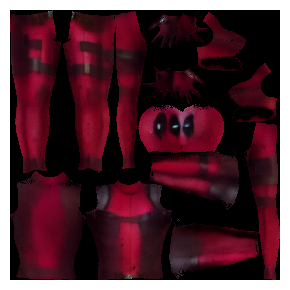

In [62]:
from text3d2video.artifacts.texture_artifact import TextureArtifact
from text3d2video.utilities.ipython_utils import display_ims


tex_tag = "human_mvlatest_Stormtrooper:latest"
tex_tag = "human_mvlatest_Deadpool:latest"

texture_art = TextureArtifact.from_wandb_artifact_tag(tex_tag)
texture = texture_art.read_texture()

display_ims([texture_art.read_texture_pil()])

In [102]:
from pathlib import Path
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.utilities.logging import H5Logger
import torch

decoder_paths = []

texgen_config = TexturingConfig(module_paths=decoder_paths, num_inference_steps=15)

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

input_texture = None
start_noise = 0.25

images = pipe(
    prompt,
    seq,
    conf=texgen_config,
    generator=generator,
    logger=logger,
    texture=input_texture,
    start_noise=start_noise,
)

logger.close()
logger.open_read()

100%|██████████| 15/15 [01:18<00:00,  5.23s/it]


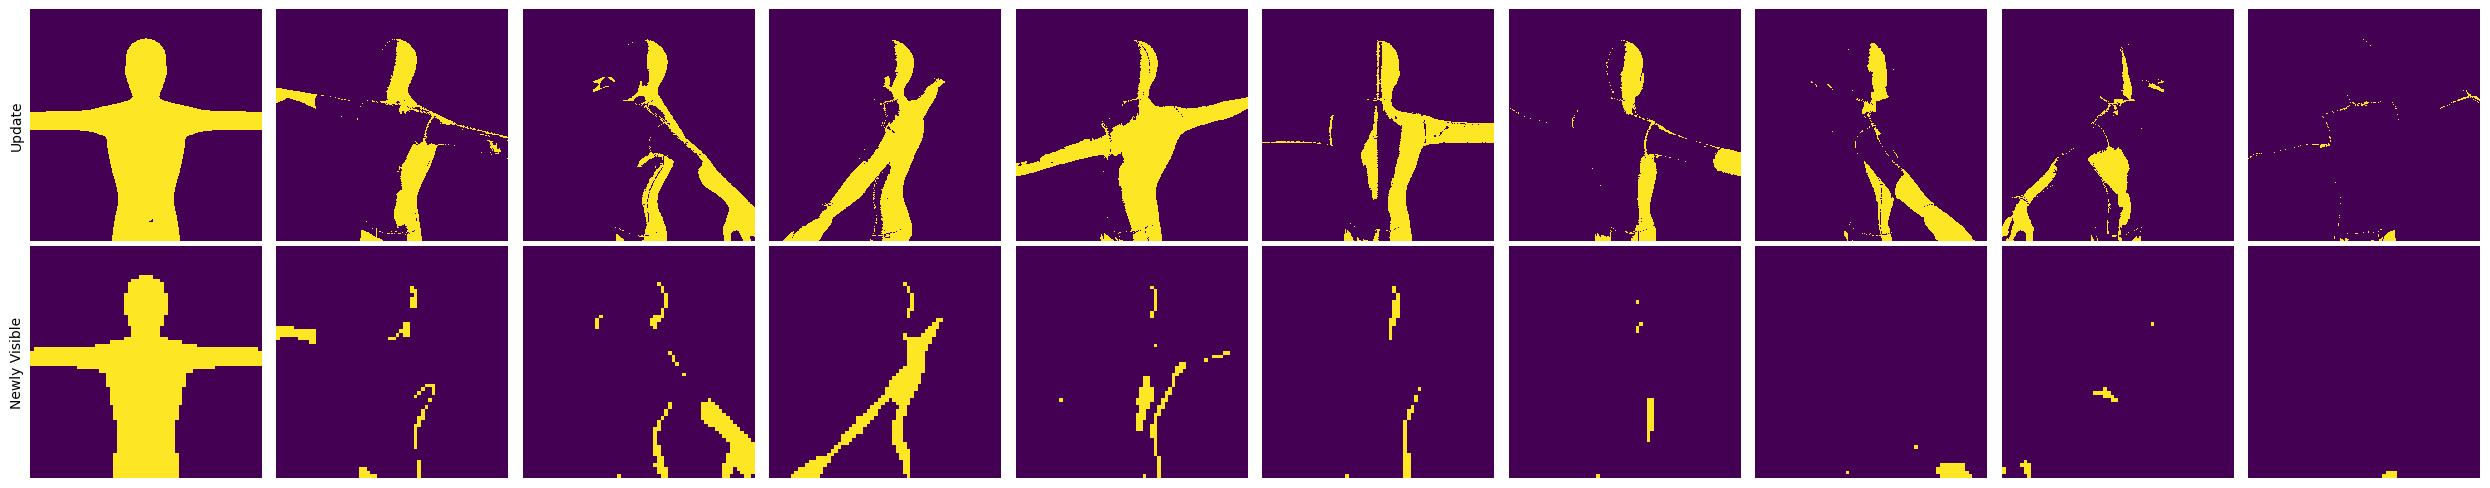

In [103]:
from text3d2video.utilities.ipython_utils import display_ims_grid

update_masks = logger.read("update_masks")
newly_visible = logger.read("newly_visible_masks")

display_ims_grid([update_masks, newly_visible], row_titles=["Update", "Newly Visible"])

In [104]:
from text3d2video.rendering import render_texture

images_vid = pil_frames_to_clip(images)
titles = [f"TexGen (start_noise={start_noise})"]
videos = [images_vid]

if texture is not None:
    renders_pil = render_texture(
        seq.meshes, seq.cams, texture, seq.verts_uvs, seq.faces_uvs, return_pil=True
    )
    renders_vid = pil_frames_to_clip(renders_pil)
    titles = ["Renders"] + titles
    videos = [renders_vid] + videos

display_vids(videos, titles=titles)

: 

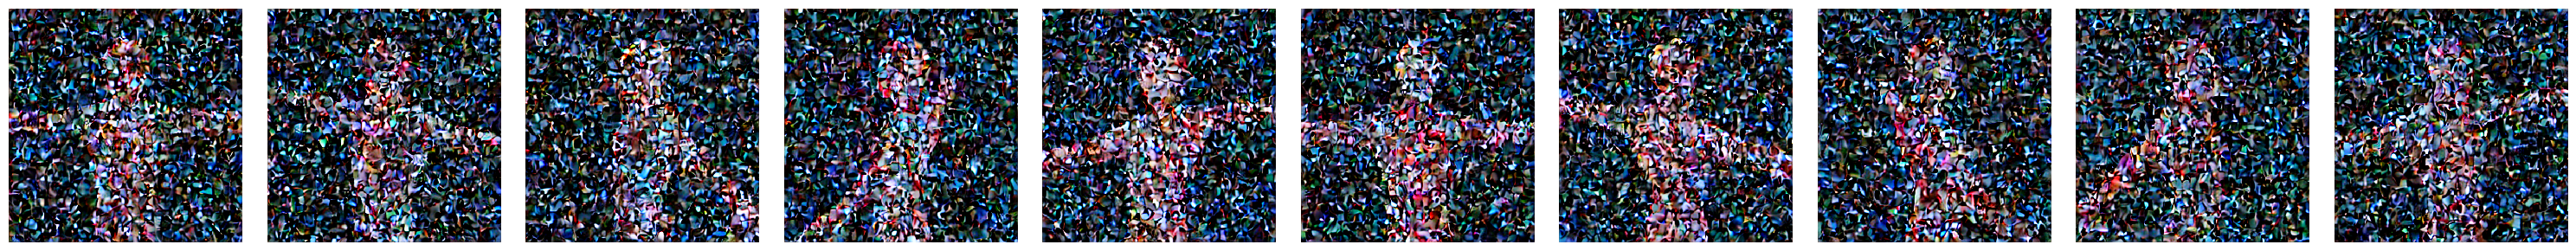

In [66]:
latents = pipe.encode_images(images)
t = pipe.scheduler.timesteps[-7]

noise = torch.randn_like(latents)
latents = pipe.scheduler.add_noise(latents, noise, t)

display_ims(pipe.decode_latents(latents))

In [17]:
import torchvision.transforms.functional as TF

from text3d2video.util import object_array
from text3d2video.utilities.ipython_utils import display_ims_grid

ts = sorted(logger.key_values("clean_im", "t"), reverse=True)
frame_is = sorted(logger.key_values("clean_im", "frame_i"))

t_vis = ts[0]
print(t_vis)

to_pil = TF.to_pil_image

clean_ims = [
    logger.read("clean_im", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is
]
rendered = [
    logger.read("rendered", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is
]

grid = object_array([rendered, clean_ims])
display_ims_grid(grid)

KeyError: "Unable to synchronously open object (object 'clean_im' doesn't exist)"

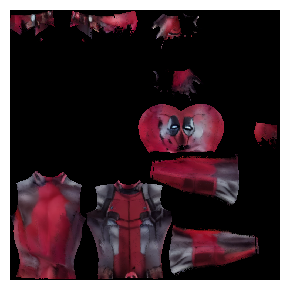

In [9]:
# project to texture
from text3d2video.backprojection import (
    aggregate_views_uv_texture_mean,
    compute_texel_projection,
)
from text3d2video.utilities.ipython_utils import display_ims


texture_res = 1000
projections = [
    compute_texel_projection(
        m, c, verts_uvs, faces_uvs, texture_res, raster_res=2000
    )
    for m, c in zip(meshes, cams)
]

texturing_frames_pt = [TF.to_tensor(f) for f in images]
texturing_frames_pt = torch.stack(texturing_frames_pt).cuda()
texture = aggregate_views_uv_texture_mean(texturing_frames_pt, texture_res, projections)

display_ims([texture.cpu()])

In [22]:
texture = logger.read("clean_tex", t=ts[-1]).cuda()
display_ims([texture.cpu()])

NameError: name 'ts' is not defined

In [23]:
from text3d2video.rendering import render_texture


anim = AnimationArtifact.from_wandb_artifact_tag("rumba_20:latest")
anim_cams, anim_meshes = anim.load_frames()
anim_verts_uvs, anim_faces_uvs = anim.uv_data()

renders = render_texture(
    anim_meshes, anim_cams, texture, anim_verts_uvs, anim_faces_uvs, return_pil=True
)

display_vid(pil_frames_to_clip(renders))